# Step1資料準備

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
(x_train_10,y_train_10),(x_test_10,y_test_10)=cifar10.load_data()
y_train_10 = to_categorical(y_train_10)
y_test_10 = to_categorical(y_test_10)



In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from tensorflow.keras.layers import Lambda, Dropout,Input, Activation, Dense, GlobalAveragePooling2D, Conv2D,Add, BatchNormalization,DepthwiseConv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers,regularizers
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import Callback,LearningRateScheduler, TensorBoard, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
import Model_mobilenet
from Model_mobilenet import MobileNet,MobileNet_drop
from image_noise import Rand_Augment

In [3]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


### unlabel data讀取,標籤,篩選

In [4]:
##load 重新標籤完的dataset
x_train_student=np.load('x_train_student_2.npy')
y_train_student=np.load('y_train_student_2.npy')

### Student_model_1的訓練資料量總共有32800張

In [5]:
x_train_student.shape

(120000, 32, 32, 3)

### Student_model_2 訓練

In [6]:
img_augment = Rand_Augment(Numbers=2, max_Magnitude=10)

def get_random_data(x_train_i, y_train_i, data_aug):
    x = array_to_img(x_train_i)

    if data_aug:

        seed_image = img_augment(x)
        seed_image = img_to_array(seed_image)

    else:
        seed_image = x_train_i

    seed_image = seed_image / 255

    return seed_image, y_train_i

def data_generator(x_train, y_train, batch_size, data_aug):
    '''data generator for fit_generator'''
    n = len(x_train)
    i = 0
    while True:
        image_data = []
        label_data = []
        for b in range(batch_size):
            if i==0:
                p = np.random.permutation(len(x_train))
                x_train = x_train[p]
                y_train = y_train[p]
            image, label = get_random_data(x_train[i], y_train[i], data_aug)
            image_data.append(image)
            label_data.append(label)
            i = (i+1) % n
        image_data = np.array(image_data)
        label_data = np.array(label_data)
        yield image_data, label_data

In [7]:
img_input=Input(shape=(32,32,3))
output = MobileNet_drop(img_input,dropout_set=0.1)
student_model_2 = Model(img_input,output)
student_model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 24)        672       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 24)        96        
_________________________________________________________________
activation (Activation)      (None, 16, 16, 24)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 16, 24)        240       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 24)        96        
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 24)        0     

In [8]:
import os

In [9]:
log_dir = 'logs/softlabel/student1_2/'

checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',\
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

student_model_2.compile(loss = "categorical_crossentropy",optimizer = "adam", metrics = ["accuracy"])

batch_size = 64
steps_per_epoch = x_train_student.shape[0] // batch_size
validation_steps = x_test_10.shape[0] // batch_size
history = student_model_2.fit_generator(data_generator(x_train_student, y_train_student, batch_size, data_aug = True),
                                      initial_epoch=0,
                                      epochs=50,
                                      steps_per_epoch = steps_per_epoch,
                                      validation_data = data_generator(x_test_10, y_test_10, batch_size, data_aug = False),
                                      validation_steps = validation_steps,
                                      callbacks=[checkpoint, reduce_lr, early_stopping])




Epoch 1/50
1875/1875 [==============================] - 235s 125ms/step - loss: 2.0171 - accuracy: 0.2685 - val_loss: 1.8639 - val_accuracy: 0.3895
Epoch 2/50
1875/1875 [==============================] - 231s 123ms/step - loss: 1.7509 - accuracy: 0.3878 - val_loss: 1.4430 - val_accuracy: 0.4720
Epoch 3/50
1875/1875 [==============================] - 234s 125ms/step - loss: 1.6093 - accuracy: 0.4556 - val_loss: 1.2081 - val_accuracy: 0.5616
Epoch 4/50
1875/1875 [==============================] - 227s 121ms/step - loss: 1.5044 - accuracy: 0.5053 - val_loss: 1.1299 - val_accuracy: 0.5889
Epoch 5/50
1875/1875 [==============================] - 226s 121ms/step - loss: 1.4060 - accuracy: 0.5510 - val_loss: 1.0572 - val_accuracy: 0.6302
Epoch 6/50
1875/1875 [==============================] - 232s 124ms/step - loss: 1.3345 - accuracy: 0.5846 - val_loss: 0.9459 - val_accuracy: 0.6764
Epoch 7/50
1875/1875 [==============================] - 230s 122ms/step - loss: 1.2818 - accuracy: 0.6127 - val_

In [10]:
student_model_2.save('student_model_2_624.h5')
history.history.keys()
student_2 = pd.DataFrame(history.history, index=range(1,len(history.history['loss'])+1))
student_2.to_csv('E:/NCHU_PHD/10902sml/report2/final_624/student_2.CSV')



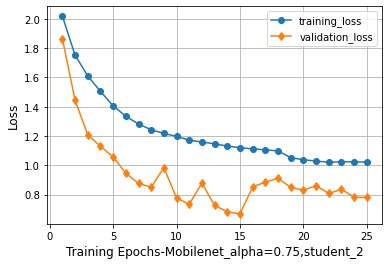

In [11]:
from matplotlib import pyplot as plt
plt.plot(student_2['loss'], marker='o', label='training_loss')
plt.plot(student_2['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs-Mobilenet_alpha=0.75,student_2', fontsize=12)
plt.grid()
plt.legend()

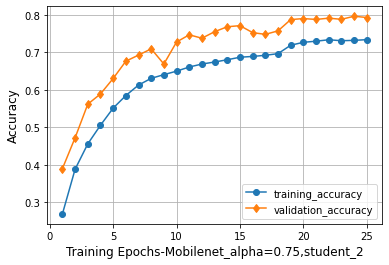

In [12]:
plt.plot(student_2['accuracy'], marker='o', label='training_accuracy')
plt.plot(student_2['val_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs-Mobilenet_alpha=0.75,student_2', fontsize=12)
plt.grid()
plt.legend()

### Student_model_2 作為教師模型對unlabel data進行偽標籤

In [14]:
###############student 1 to teacher pseudo label 1 
img_path = r"E:\NCHU_PHD\10902sml\data_set\add"
img_list = os.listdir(img_path)

x_train_imgnet = []

for i in img_list:
    abs_path = os.path.join(img_path, i)
    temp = load_img(abs_path)
    temp = img_to_array(temp)
    x_train_imgnet.append(temp)

x_train_imgnet = np.array(x_train_imgnet)

batch_size = 40
step = int(x_train_imgnet.shape[0] / batch_size)
print(step)

y_train_imgnet_dummy = []

for i in range(step):
    x_temp = x_train_imgnet[batch_size*i:batch_size*(i+1)]
    x_temp = x_temp / 255.
    temp = student_model_2.predict(x_temp)
    y_train_imgnet_dummy.extend(temp)

y_train_imgnet_dummy = np.array(y_train_imgnet_dummy)

#np.save('y_train_imgnet_dummy',y_train_imgnet_dummy)


threhold = 0.3
y_train_imgnet_dummy_th =  y_train_imgnet_dummy[np.max(y_train_imgnet_dummy, axis=1) > threhold]
x_train_imgnet_th = x_train_imgnet[np.max(y_train_imgnet_dummy, axis=1) > threhold]

### 挑出confindence score > 0.3的圖片總共有  18354 張

### 將label data 與unlabel data合併

####用list包


y_student_all_dummy_label = np.argmax(y_train_imgnet_dummy_th, axis=1)

u, counts = np.unique(y_student_all_dummy_label, return_counts=True)
print(u, counts)

student_label_max =  max(counts)

y_student_per_label = []
y_student_per_img_path = []

for i in range(10):
    temp_l = y_train_imgnet_dummy_th[y_student_all_dummy_label == i]
    print(i, ":", temp_l.shape)
    y_student_per_label.append(temp_l)
    temp_i = x_train_imgnet_th[y_student_all_dummy_label == i]
    print(i, ":", temp_i.shape)
    y_student_per_img_path.append(temp_i)

y_student_per_label_add = []
y_student_per_img_add = []

for i in range(10):
    num = y_student_per_label[i].shape[0]
    temp_l = y_student_per_label[i]
    temp_i = y_student_per_img_path[i]
    add_num = student_label_max - num
    q, mod = divmod(add_num, num)
    print(q, mod)
    temp_l_tile = np.tile(temp_l, (q+1, 1))
    temp_i_tile = np.tile(temp_i, (q+1, 1, 1, 1))
    temp_l_add = temp_l[:mod]
    temp_i_add = temp_i[:mod]
    temp_l_new = np.concatenate([temp_l_tile, temp_l_add], axis=0)

    temp_i_new = np.concatenate([temp_i_tile, temp_i_add], axis=0)

    p = (-temp_l_new[:,0]).argsort()
    temp_l_new = temp_l_new[p]
    temp_i_new= temp_i_new[p]
    y_student_per_label_add.append(temp_l_new[:7000])
    y_student_per_img_add.append(temp_i_new[:7000])

print([len(i) for i in y_student_per_label_add])

student_train_img = np.concatenate(y_student_per_img_add, axis=0)
student_train_label = np.concatenate(y_student_per_label_add, axis=0)

x_train_student = np.concatenate([x_train_10, student_train_img], axis=0)
y_train_student = np.concatenate([y_train_10, student_train_label], axis=0)


1750
[0 1 2 3 4 5 6 7 8 9] [7754 6111 6518 5671 8917 3930 8405 6682 5977 6543]
0 : (7754, 10)
0 : (7754, 32, 32, 3)
1 : (6111, 10)
1 : (6111, 32, 32, 3)
2 : (6518, 10)
2 : (6518, 32, 32, 3)
3 : (5671, 10)
3 : (5671, 32, 32, 3)
4 : (8917, 10)
4 : (8917, 32, 32, 3)
5 : (3930, 10)
5 : (3930, 32, 32, 3)
6 : (8405, 10)
6 : (8405, 32, 32, 3)
7 : (6682, 10)
7 : (6682, 32, 32, 3)
8 : (5977, 10)
8 : (5977, 32, 32, 3)
9 : (6543, 10)
9 : (6543, 32, 32, 3)
0 1163
0 2806
0 2399
0 3246
0 0
1 1057
0 512
0 2235
0 2940
0 2374
[7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000]


In [15]:
np.save('x_train_student_3',x_train_student)
np.save('y_train_student_3',y_train_student)

In [16]:
###test
img_path = "E:/NCHU_PHD/10902sml/data_set/add_test"
img_list = os.listdir(img_path)

x_test = []
y_test = []

for i in img_list:
    img_list_= img_path +"/"+i
    for j in os.listdir(img_list_):
        abs_path = img_path +"/"+i +"/"+j
        temp = load_img(abs_path)
        temp = img_to_array(temp)
        x_test.append(temp)
        y_test.append(i)
    
x_test = np.array(x_test)
y_test = np.array(y_test).reshape((500, 1))
y_test = to_categorical(y_test)

def my_eval(model,x,t):
    ev = model.evaluate(x,t, batch_size=10)
    print("loss:"+str(round(ev[0],4)))
    print("acc: "+str(ev[1]))

my_eval(student_model_2,x_test/255,y_test)

500/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

loss:2.0122
acc: 0.554
